# **Machine Learning Model**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os,pickle
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
#from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

## **ML On TF-IDF Weighted W2V**

In [ ]:
#loading tfidf weighted glove
X_train = pd.read_csv('/content/drive/MyDrive/Personal_Project/Fetures_Extraction/TFID_Weighted_W2V/_tfidf_w2vtrain_data.csv')
X_test = pd.read_csv('/content/drive/MyDrive/Personal_Project/Fetures_Extraction/TFID_Weighted_W2V/tfidf_w2v_test_data.csv')
y_test = pd.read_csv('/content/drive/MyDrive/Personal_Project/Fetures_Extraction/TFID_Weighted_W2V/tfidf_w2v_train_y.csv')
y_train = pd.read_csv('/content/drive/MyDrive/Personal_Project/Fetures_Extraction/TFID_Weighted_W2V/tfidf_w2v_test_y.csv')
X_train = X_train.drop(columns=['q1_glove','q2_glove'])
X_test = X_test.drop(columns=['q1_glove','q2_glove'])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(70000, 218)
(30000, 218)
(70000, 1)
(30000, 1)


In [ ]:
X_train.head(3)

,q1len,q2len,q1_n_words,q2_n_words,freq_qid1,freq_qid2,word_common,word_total,word_share,freq_q1+q2,...,g_182,g_183,g_184,g_185,g_186,g_187,g_188,g_189,g_190,g_191
0,54,56,10,10,1,1,6.0,19.0,0.315789,2,...,-2.701354,2.716441,-0.510052,6.447781,-2.949746,-0.962468,2.531881,6.010862,1.527958,1.486945
1,56,45,9,8,1,1,8.0,17.0,0.470588,2,...,3.914964,0.328768,-2.454020,0.270393,-9.784351,-0.421203,2.982829,3.221098,-0.517070,7.156083
2,111,96,19,17,4,3,8.0,34.0,0.235294,7,...,-2.047053,-4.732654,-0.826601,6.169578,0.445108,-2.095889,4.520428,-1.048259,0.624426,6.458432


In [ ]:
X_test.head(3)

,q1len,q2len,q1_n_words,q2_n_words,freq_qid1,freq_qid2,word_common,word_total,word_share,freq_q1+q2,...,g_182,g_183,g_184,g_185,g_186,g_187,g_188,g_189,g_190,g_191
0,45,51,6,7,14,14,4.0,13.0,0.307692,28,...,3.969435,-4.386923,5.229480,6.589633,-13.695223,-2.685117,8.354160,8.374036,-7.196234,19.219431
1,82,53,13,9,3,1,0.0,21.0,0.000000,4,...,-2.151148,1.043688,1.686962,1.703929,-1.317777,-2.861869,1.587751,2.456052,-3.206597,6.237281
2,66,28,12,6,42,46,4.0,18.0,0.222222,88,...,-1.119629,-1.178872,0.693722,0.528563,2.404150,5.529877,-6.858145,8.659120,-0.890519,1.957024


In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    #[TN FP]
    #[FN TP]   
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #precision = true positive / predicted positive
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #recall = true positive/ actual positive
    #divide each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    # cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True,  fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [ ]:
from sklearn.metrics import log_loss

# **Logistic Regression**

For values of alpha =  1e-05 The log loss is: 0.40689619656342363
For values of alpha =  0.0001 The log loss is: 0.4125160759089444
For values of alpha =  0.001 The log loss is: 0.4146485191559921
For values of alpha =  0.01 The log loss is: 0.3943245507998153
For values of alpha =  0.1 The log loss is: 0.4205835577362309
For values of alpha =  1 The log loss is: 0.4551889081715811
For values of alpha =  10 The log loss is: 0.5061304186070562


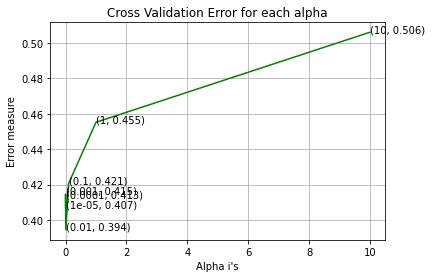

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  0.01 The train log loss is: 0.38511126714780586
For values of best alpha =  0.01 The test log loss is: 0.3943245507998153
Total number of data points : 30000


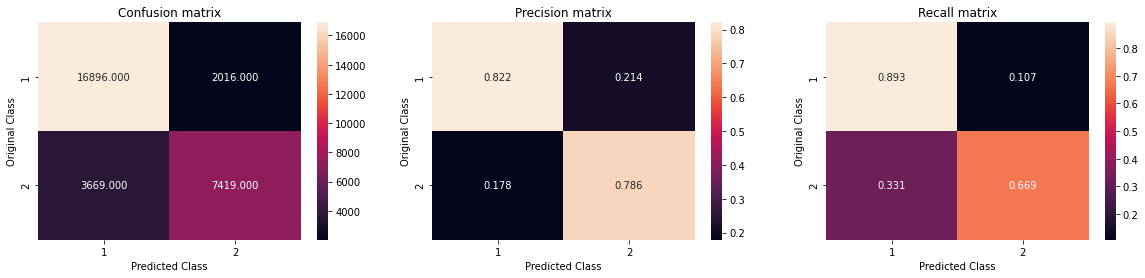

In [ ]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [ ]:
y_test.values

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [ ]:
pred = np.argmax(predict_y,axis=1)
pred = pred.reshape(-1,1)

In [ ]:
pred

array([[1],
       [0],
       [1],
       ...,
       [1],
       [0],
       [0]])

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.86     18912
           1       0.79      0.67      0.72     11088

    accuracy                           0.81     30000
   macro avg       0.80      0.78      0.79     30000
weighted avg       0.81      0.81      0.81     30000



# **Linear SVM with hinge Loss**

For values of alpha =  1e-05 The log loss is: 0.4060422440236008
For values of alpha =  0.0001 The log loss is: 0.4138589172038047
For values of alpha =  0.001 The log loss is: 0.40756399968904033
For values of alpha =  0.01 The log loss is: 0.39436667438525014
For values of alpha =  0.1 The log loss is: 0.4169084766869477
For values of alpha =  1 The log loss is: 0.4426180713174131
For values of alpha =  10 The log loss is: 0.4924010747968385


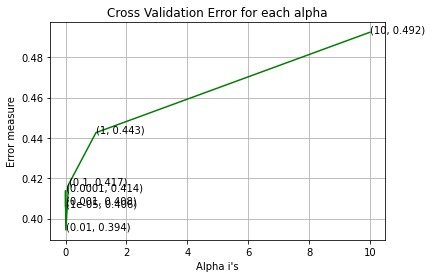

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  0.01 The train log loss is: 0.38630324884340106
For values of best alpha =  0.01 The test log loss is: 0.39436667438525014
Total number of data points : 30000


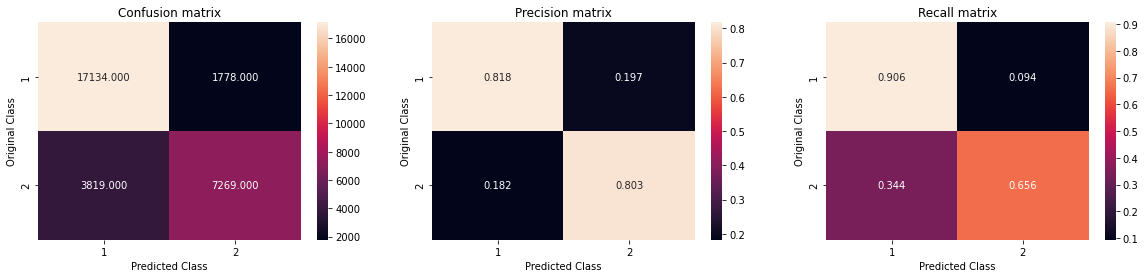

In [ ]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [ ]:
y_test.values

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [ ]:
pred = np.argmax(predict_y,axis=1)
pred = pred.reshape(-1,1)

In [ ]:
pred

array([[1],
       [0],
       [1],
       ...,
       [1],
       [0],
       [0]])

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86     18912
           1       0.80      0.66      0.72     11088

    accuracy                           0.81     30000
   macro avg       0.81      0.78      0.79     30000
weighted avg       0.81      0.81      0.81     30000

